In [2]:
import numpy as np
import os, sys
import scipy

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Cosmology
from astropy.constants import h, c
import astropy.units as u
from astropy.cosmology import Planck15 as Planck15_cosmo
from astropy.cosmology import z_at_value

sys.path.append('reionization/')
import reionization

%matplotlib inline

# All the plots

Make nice plots for $\dot{N}_\mathrm{ion}$ paper

# Figure setup

In [3]:
# Figure setup
mpl.rcParams['font.size'] = 12
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'arial'
# mpl.rcParams['mathtext.rm'] = 'Helvetica Neue LT'
mpl.rcParams['axes.unicode_minus'] = False

dpi = 300

figsize = (6,4)
lw      = 3

# Colors
col2      = '0.6'     # CMB + dark fraction
colall    = '#4f1a50'  # all constraints
col_prior = '0.85'     # prior

col_N19 = '#e77429'    # Naidu+19
col_F19 = '#abebca'    # Finkelstein+19

mcol = '#e77429'       # markers

# Labels
label_z    = 'Redshift, z'
label_rhoL = r'$\log_{10}(\rho_L \, [$erg s$^{-1}$ Hz$^{-1}$ Mpc$^{-3}])$'
label_Nion = r'$\log_{10}(\dot{N}_\mathrm{ion} \, [$s$^{-1}$ Mpc$^{-3}])$'
label_xHII = r'IGM ionized fraction, $\overline{x}_\mathrm{HII}$'
label_xHI  = r'IGM neutral fraction, $\overline{x}_\mathrm{HI}$'
label_tau  = r'CMB electron scattering optical depth, $\tau_\mathrm{es}$'

label_2obs   = r'$\tau_\mathrm{es}$ + dark fraction'
label_allobs = r'+ Ly$\alpha$ damping'

In [4]:
# Useful plotting functions

def plt_errorbar_obs(x, y, ax=None, xerr=None, yerr=None,
                 uplims=None, lolims=None, 
                 marker='o', ms=15, col='0.3',
                 mew=1.2, elw=1.2, ls='none',
                 label=None, zorder=15):
    """
    Plot data with errorbars with nice defaults
    """
    if ax:
        ln = ax.errorbar(x, y, yerr=yerr, xerr=xerr,
                 uplims=uplims, lolims=lolims, 
                 marker=marker, ms=ms, 
                 capsize=3, mew=mew,
                 color=col, mfc='w', mec=col, 
                 elinewidth=elw, ls=ls, 
                 label=label, zorder=zorder)
    else:
        ln = plt.errorbar(x, y, yerr=yerr, xerr=xerr,
                 uplims=uplims, lolims=lolims, 
                 marker=marker, ms=ms, 
                 capsize=3, mew=mew,
                 color=col, mfc='w', mec=col, 
                 elinewidth=elw, ls=ls, 
                 label=label, zorder=zorder)        
    
    return ln

def make_Gyr_axis(ax1, age_list=[0.1, 0.2, 0.3, 0.5, 1., 2., 13.]):
    """
    Convert an axis from redshift to Gyr
    """
    
    ax2 = ax1.twiny()
    ages     = np.array(age_list)*u.Gyr
    ageticks = [z_at_value(Planck15_cosmo.age, a) for a in ages]

    ax2.set_xticks(ageticks)
    ax2.set_xticklabels(['{:g}'.format(age.value) for age in ages])
    ax2.minorticks_off()
    ax2.set_xlim(ax1.get_xlim())

    ax2.set_xlabel('Gyr since Big Bang')

    return

# Make colormap
def make_cmap_line(array, c_map='viridis_r'):
    """
    Map array to color map
    """
    c_norm = mpl.colors.Normalize(vmin=np.min(array), vmax=np.max(array))

    s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
    s_map.set_array([])
    
    return s_map

def ax_colorbar(ax, s_map, label, fiducial=None):
    """
    Plot colorbar on top of subplot
    """
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="7%", pad="2%")
    fig.add_axes(cax)
    cb = fig.colorbar(s_map, orientation='horizontal', cax=cax)
    cax.xaxis.set_ticks_position("top")
    cb.set_label(label, labelpad=-45)
    if fiducial:
        cax.axvline(fiducial, c='w')
    return

In [5]:
def confidence_interval(samples, percentile=68., axis=0):
    """
    Calculate median and confidence levels for samples
    """    
    plow  = 50. - percentile/2.
    phigh = 50. + percentile/2.
    
    med  = np.median(samples, axis=axis)
    low  = np.percentile(samples, plow, axis=axis)
    high = np.percentile(samples, phigh, axis=axis)
    
    return med, low, high

def plot_dist(samples, ztab, ax=None, z1=6., z2=8., kde_kws=None, 
              plot_conf=False, conf_shade=True,
              label=None, label_meas=True, hist=False, return_samples=False):
    
    if z2 is not None:
        dz = z2 - z1
        dist = (samples[:,np.where(ztab == z2)] - samples[:,np.where(ztab == z1)]).ravel()/dz
    else:
        dist = samples[:,np.where(ztab == z1)].ravel()
       
    med, low, high = confidence_interval(dist)
    
    if label:
        label = label
        if label_meas:
            label = label+'\n$%.2f\pm%.2f$ dex' % (med, np.std(dist))
    else:
        label = None
        
    ax_dist = sns.distplot(dist, hist=hist, kde_kws=kde_kws, ax=ax, label=label)
                               
    if plot_conf:
        x   = ax_dist.lines[-1].get_xdata()
        pdf = ax_dist.lines[-1].get_ydata()

        x_interp   = np.linspace(low, high)
        pdf_interp = np.interp(x_interp, x, pdf)
        
        if conf_shade:
            ax_dist.fill_between(x=x_interp, y1=0., y2=pdf_interp, color=ax_dist.lines[-1].get_color(), alpha=0.2)
        else: 
            ax_dist.plot([low, low],   [0., pdf_interp[0]],  color=ax_dist.lines[-1].get_color(), 
                         alpha=0.6, ls='dashed', lw=1)
            ax_dist.plot([high, high], [0., pdf_interp[-1]], color=ax_dist.lines[-1].get_color(),
                         alpha=0.6, ls='dashed', lw=1)
        
    if return_samples:
        return np.ravel(dist)
    else:
        return

## Observational constraints

Constraints on reionization from:

- [Planck 2015](https://ui.adsabs.harvard.edu/abs/2016A%26A...596A.108P/abstract) CMB optical depth
- [Planck 2018](https://ui.adsabs.harvard.edu/abs/2018arXiv180706209P/abstract) CMB optical depth
- [Becker & Bolton 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.436.1023B/abstract) $\dot{N}_\mathrm{ion}$ measurements
- Galaxy Lyman-alpha EW evolution ([Mason+18](https://ui.adsabs.harvard.edu/abs/2018ApJ...856....2M/abstract),[+19](https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.3947M/abstract), [Hoag+19](https://ui.adsabs.harvard.edu/abs/2019arXiv190109001H/abstract))
- Lyman-alpha emitter clustering ([Sobacchi & Mesinger 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.453.1843S/abstract))
- QSO Lyman-alpha damping wings ([Davies+18](https://ui.adsabs.harvard.edu/abs/2018ApJ...864..142D/abstract), [Greig+19](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.5094G/abstract))

In [6]:
# -----------------------------------------
# CMB tau_e
Planck15 = {'tau':np.array([0.058]), 'tau_err':np.array([0.012])}
Planck18 = {'tau':np.array([0.054]), 'tau_err':np.array([0.007])}

# -----------------------------------------
# Becker + Bolton 2013
BB13_nion = {'z':np.array([2.4, 3.2, 4., 4.75]),
            'nion':np.array([-0.046, -0.211, -0.139, -0.014])+51., # log Nion + 51
            'nion_err_l':np.array([0.372, 0.352, 0.346, 0.355]),
            'nion_err_u':np.array([0.444, 0.445, 0.451, 0.454]),
            'lab':'Becker & Bolton 2013'}

# -----------------------------------------
# Reionization history constraints

# Lya EW distribution inference Mason+18a,+19,Hoag+19
lya_EW =  {'z':[6.9,7.6,7.8], 'z_err':[0.5,0.6,0.6], 
           'xHI':np.array([0.59,0.88,0.76]), 
           'xHI_err':np.array([[0.15, 0.10, 0.],[0.11, 0.05, 0.]]),
           'lim':[False,False,'low'],
           'sym':'*', 's':18, 'lab':r'Ly$\alpha$ EW evolution'}

# Clustering from Sobacchi & Mesinger 2015 (of Ouchi+2010)
# x_HI < 0.5
clust = {'z':[6.6], 'xHI':np.array([0.5]), 'xHI_err':[[0.],[0.]], 
         'lim':['up'],
         'sym':'s', 's':13, 'lab':'LAE clustering'} #'Sobacchi+15'}#

# Lya forest dark pixels from McGreer+2015
dark =  {'z':[5.6,5.9,6.1], 
         'xHI':np.array([0.04,0.06,0.38]), 
         'xHI_err':np.array([[0., 0., 0.],[0.05, 0.05, 0.20]]), 
         'lim':['up', 'up', 'up'],
         'sym':'o', 's':13, 'lab':r'Dark fraction'} #'McGreer+15'}#

# QSO damping wings 
# Davies+18  x_HI(z=7.09) = 0.48\pm0.26
#            x_HI(7.54)   = 0.6+0.20-0.23
# Greig+19 x_HI(7.54)   = 0.21+0.17-0.19
damp = {'z':[7.09, 7.54, 7.09, 7.54], 
        'xHI':np.array([0.48, 0.6, 0.40, 0.21]),
        'xHI_err':np.array([[0.26, 0.23, 0.19, 0.19],[0.26, 0.2, 0.21, 0.17]]),
        'lim':[False,False,False,False],
        'sym':'D', 's':11, 'lab':'QSO damping wings'}

xHI_obs = [lya_EW, clust, dark, damp]

## Other $\dot{N}_\mathrm{ion}$ models

Load models from:
  - [Bouwens+15](https://ui.adsabs.harvard.edu/abs/2015ApJ...811..140B/abstract)
  - [Robertson+15](https://ui.adsabs.harvard.edu/abs/2015ApJ...802L..19R/abstract)
  - [Finkelstein+19](https://ui.adsabs.harvard.edu/abs/2019arXiv190202792F/abstract)
  - [Naidu+19](https://ui.adsabs.harvard.edu/abs/2019arXiv190713130N/abstract)

In [7]:
# Nion models
B15 = np.genfromtxt('obs_constraints/Bouwens+15_Nion.txt', names=True)
R15 = np.genfromtxt('obs_constraints/Robertson+15_Nion.txt', names=True, skip_header=1)
F19 = np.genfromtxt('obs_constraints/Finkelstein+19_Ndotion_total.txt', names=['z', 'l_68', 'med', 'u_68'], skip_header=4)

# Naidu+19
# fesc = 0.21, Muv<-13.5
N19_z = np.array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
N19_nion = np.array([51.44366185, 51.22935365, 50.9753296 , 50.57753508, 50.26799426, 49.90811206, 49.41868487, 48.91202686, 48.48195611, 47.85727196])

## Instantiate Reion, redshift setup

In [8]:
# Set up redshifts
dz=1.
ztab = np.arange(4.,15., 1.)
ndim = len(ztab)
big_ztab = np.linspace(0.,ztab.max(), 100)
print(ztab)

# Start a Reion object
reion = reionization.ReionizationTimeline(ztab=ztab)

# Useful conversion factor
cm3_to_Mpc3 = (1.E6 * reion.pc) ** 3.

[ 4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]
Using Planck15 cosmology


## Galaxies & Quasar $\dot{N}_\mathrm{ion}$ models

Create simple models for $\dot{N}_\mathrm{ion}$ for galaxies and quasars

### Quasars $\dot{N}_\mathrm{ion}$

$$ \dot{N}_\mathrm{ion,Q} = f_\mathrm{esc,Q} \int d\nu \, \frac{\epsilon_{\nu}}{h\nu} $$

the integral limits are from 1-4 Ry (the energy of hydrogen-ionizing photons) and $f_\mathrm{esc,Q}$ is the ionizing photon escape fraction from quasars (usually assumed $\sim1$). The UV SED of quasars is assumed to follow a double-power law, $\epsilon_\nu \propto \nu^\alpha$, with a pivot at 912A. For <912A we use $\alpha=-1.70$.

Emissivity data from [Kulkarni+18](https://ui.adsabs.harvard.edu/abs/2018arXiv180709774K/abstract), data and code on [github](https://github.com/gkulkarni/QLF).

In [9]:
# Kulkarni+18 mega AGN database fit
def load_K18_QSOs(M=-21.):
    """
    Load data tables from Kulkarni+18
    
    M can be -21 or -18 only
    """
    
    data = np.load('obs_constraints/Kulkarni+18_e912_%.0f_2.npz' % -M)
    z        = data['z']
    med_912  = data['median']
    down_912 = data['up']   # for some reason these are switched?
    up_912   = data['down']
    
    return z, med_912, down_912, up_912 


def quasar_nion(eps_912, ryd_range=[1.,4.], alpha=-1.7):
    """
    Get H ionizing photon production from 912 emissivity
    (Madau & Haardt 2015)
    alpha=-1.7 (Lusso+15)
    """
    ryd = np.linspace(ryd_range[0], ryd_range[1])
    photon_energy = (ryd*u.rydberg).to(u.erg)       # photon energy range in ergs
    photon_freq   = photon_energy/h.to(u.erg * u.s) # photon frequency range in Hz
    
    eps_912 = eps_912 * (u.erg/u.s/u.Hz/u.Mpc**3.)
    eps_nu  = eps_912[:,None] * (photon_freq/photon_freq[0])**alpha
    
    nion = np.trapz(eps_nu/photon_energy, photon_freq)
    
    return nion.to(1./(u.s*u.Mpc**3.))


def get_nion_K18_QSOs(M=-21., alpha=-1.7):
    """
    Get log10(nion) from Kulkarni eps_912
    """
    z, eps912_med, eps912_l, eps912_u = load_K18_QSOs(M=M)
    
    nion_med = np.log10(quasar_nion(eps912_med, alpha=alpha).value)
    nion_l   = np.log10(quasar_nion(eps912_l, alpha=alpha).value)
    nion_u   = np.log10(quasar_nion(eps912_u, alpha=alpha).value)
    
    return z, nion_med, nion_l, nion_u

# Load quasar nion
z, nion_Q21_med, nion_Q21_l, nion_Q21_u = get_nion_K18_QSOs(M=-21)
z, nion_Q18_med, nion_Q18_l, nion_Q18_u = get_nion_K18_QSOs(M=-18)

# Save to dictionary
K18 = {}
K18['z']    = z
K18['med']  = np.median(np.vstack((nion_Q21_med, nion_Q18_med)), axis=0)
K18['l_68'] = nion_Q21_l
K18['u_68'] = nion_Q18_u

### Galaxies nion

$$ \dot{N}_\mathrm{ion ,G} = f_\mathrm{esc} \xi_\textrm{ion} \rho_L$$

where $f_\mathrm{esc}$ is the fraction of ionizing photons which escape galaxies to the IGM; $\xi_\textrm{ion}$ is the production rate of ionizing photons per UV luminosity, in Hz/ergs, which depends on the stellar populations' initial mass function, metallicity, age and dust content; and $\rho_L$ is the dust-corrected UV luminosity density.

Here we use $\rho_L$ from the [Mason, Trenti & Treu 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...813...21M/abstract) UV luminosity function model.

In [10]:
def lognion_gal(lumdens, fesc, logxi_ion):
    """
    Get log10(nion) for galaxies
    """
    return np.log10(lumdens*fesc*10**logxi_ion)

# fesc and xi_ion test values
fesc_test, log_xiion_test = 0.2, 25.2

# Minimum UV absolute magnitude to integrate to
M_l, M_u = -18., -12.
ldens_file = 'obs_constraints/Mason+15_lum_dens.txt'
M15_ldens  = np.genfromtxt(ldens_file, names=True, skip_header=2)

M15 = {}
M15['z']    = M15_ldens['z']
M15['l_68'] = lognion_gal(lumdens=10**M15_ldens['%.0f' % (-10*M_l)], fesc=fesc_test, logxi_ion=log_xiion_test)
M15['u_68'] = lognion_gal(lumdens=10**M15_ldens['%.0f' % (-10*M_u)], fesc=fesc_test, logxi_ion=log_xiion_test)

### dNion/dz

Calculate $d\log_{10}\dot{{N}}_\textrm{ion}/dz$ between z=6 and z=8 from other models to compare to our posteriors

In [11]:
z1 = 6.
z2 = 8.
dz = z2 - z1

# Finkelstein+19
dnion_F19_med  = (F19['med'][F19['z']==z2] - F19['med'][F19['z']==z1])/dz
dnion_F19_high = (F19['u_68'][F19['z']==z2] - F19['l_68'][F19['z']==z1])/dz
dnion_F19_low  = (F19['l_68'][F19['z']==z2] - F19['u_68'][F19['z']==z1])/dz
dnion_F19 = {'dnion':dnion_F19_med, 'err':[[dnion_F19_med-dnion_F19_low],[dnion_F19_high-dnion_F19_med]], 
             'label':'Finkelstein+19'} # calculated

# Mason+15
def dnion_M15_Muv(Muv=-20., z1=z1, z2=z2):
    lognion = lognion_gal(lumdens=10**M15_ldens['%.0f' % (-10*Muv)], fesc=fesc_test, logxi_ion=log_xiion_test)
    dnion   = (lognion[np.argmin(np.abs(M15['z']-z2))] - lognion[np.argmin(np.abs(M15['z']-z1))])/dz
    return dnion

dnion_M15_high = (M15['u_68'][np.argmin(np.abs(M15['z']-z2))] - M15['u_68'][np.argmin(np.abs(M15['z']-z1))])/dz
dnion_M15_low  = (M15['l_68'][np.argmin(np.abs(M15['z']-z2))] - M15['l_68'][np.argmin(np.abs(M15['z']-z1))])/dz
dnion_M15 = {'dnion':[dnion_M15_low, dnion_M15_high], 
             'label':'Galaxies'} # calculated

# Kulkarni+18
dnion_K18_high = (K18['u_68'][np.argmin(np.abs(K18['z']-z2))] - K18['u_68'][np.argmin(np.abs(K18['z']-z1))])/dz
dnion_K18_low  = (K18['l_68'][np.argmin(np.abs(K18['z']-z2))] - K18['l_68'][np.argmin(np.abs(K18['z']-z1))])/dz
dnion_K18 = {'dnion':[dnion_K18_low, dnion_K18_high], 
             'label':'Quasars'} # calculated

# Bouwens+15
dnion_B15 = {'dnion':-0.15, 'err':[[0.11],[0.15]], 
             'label':'Bouwens+15'} # From paper

# Naidu+19
dnion_N19_array  = N19_nion[np.where((N19_z <= z2) & (N19_z >=z1))]
dnion_N19 = {'dnion':(dnion_N19_array[-1] - dnion_N19_array[0])/dz, 'err':None, 
             'label':'Naidu+19'} # From paper

## Prior

We set the prior, $p(\dot{\mathbf{N}}_\textbf{ion})$, such that:

- $\log_{10}\dot{\mathbf{N}}_\textbf{ion}(z=5)$ is uniformly distributed between 49 and 53 ($\dot{{N}}_\textrm{ion}$ in Mpc$^{-3}$ s$^{-1}$).
- The gradient between redshift steps, $d\log_{10}\dot{\mathbf{N}}_\textbf{ion}/dz$, is uniformly distributed between -1 and 1 dex.

Note this is just for plotting. The inference is done in `nonparametric_nion.ipynb`

In [12]:
def prior_transform(u, ndim, a=-1, b=1):
    """
    prior tranform on n_ion_dot
    """
    nion_z      = (49. + 4*u[0])*np.ones(ndim)
    randn       = np.random.uniform(a, b, size=ndim-1)
    cumsum      = np.cumsum(randn)
    nion_z[1:] += cumsum
    return nion_z

Nsample = 500

np.random.seed(1)

# Draw samples from prior
random_walks = np.array([prior_transform([x], ndim=ndim) for x in np.random.uniform(size=Nsample)])

## Load Nion chains

In [13]:
diff_min, diff_max = -1, 1 # min and max of prior dnion/dz

# Dynesty chains
chains_2obs   = [r'$\tau_\mathrm{es}$ + dark fraction',
                 "chains/res_2obs_U[%.0f,%.0f]_49-53_samples.npy" % (diff_min, diff_max)]
chains_allobs = [r'+ Ly$\alpha$ damping',
                 "chains/res_allobs_U[%.0f,%.0f]_49-53_samples.npy" % (diff_min, diff_max)]

test = ''

chains1 = chains_2obs
chains2 = chains_allobs

label_2obs   = chains1[0]
label_allobs = chains2[0]

print(test, label_2obs, label_allobs)

 $\tau_\mathrm{es}$ + dark fraction + Ly$\alpha$ damping


In [14]:
# Load chains
nion_samples        = np.load(chains1[1])
nion_allobs_samples = np.load(chains2[1])

print(nion_samples.shape, nion_allobs_samples.shape)

(20000, 11) (10000, 11)


In [15]:
# Pick some samples
Nsample = 1000
np.random.seed(1)

nion_med, nion_16, nion_84 = confidence_interval(nion_samples, percentile=68., axis=0)
nion_pick = nion_samples[np.random.randint(len(nion_samples), size=Nsample)]

nion_allobs_med, nion_allobs_16, nion_allobs_84 = confidence_interval(nion_allobs_samples, percentile=68., axis=0)
nion_allobs_pick = nion_allobs_samples[np.random.randint(len(nion_allobs_samples), size=Nsample)]

# Nion plots

## photons per H atom

In [24]:
def nion_per_Hatom(log_nion_Mpc_s, z=6., tH=True):
    """
    Calculate number of ionizing photons per H atom 
    per Hubble time at redshift z (or in 1 Gyr if tH is False)
    """
    
    nion_cm_s = reion.nion_mod(log_nion_Mpc_s)
    
    time = (1.e9 * u.year).to(u.s).value # 1 Gyr in sec
    if tH:
        time = 1./Planck15_cosmo.H(z=z).to(1./u.s).value
    
    nion_per_H = time*nion_cm_s/reion.n_H
    
    return nion_per_H

print(nion_per_Hatom(nion_16[ztab == 6.]), nion_per_Hatom(nion_84[ztab == 6.]))
print(nion_per_Hatom(nion_allobs_16[ztab == 6.]), nion_per_Hatom(nion_allobs_84[ztab == 6.]))

[3.61063313] [43.33959885]
[6.65892042] [28.69159913]


## Plot all

In [25]:
Mlim_plot = np.array([-18., -15., -13.])
Mlim_plot = sorted(np.append(Mlim_plot, [Mlim_plot.min()-0.5, Mlim_plot.max()+0.5]))


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


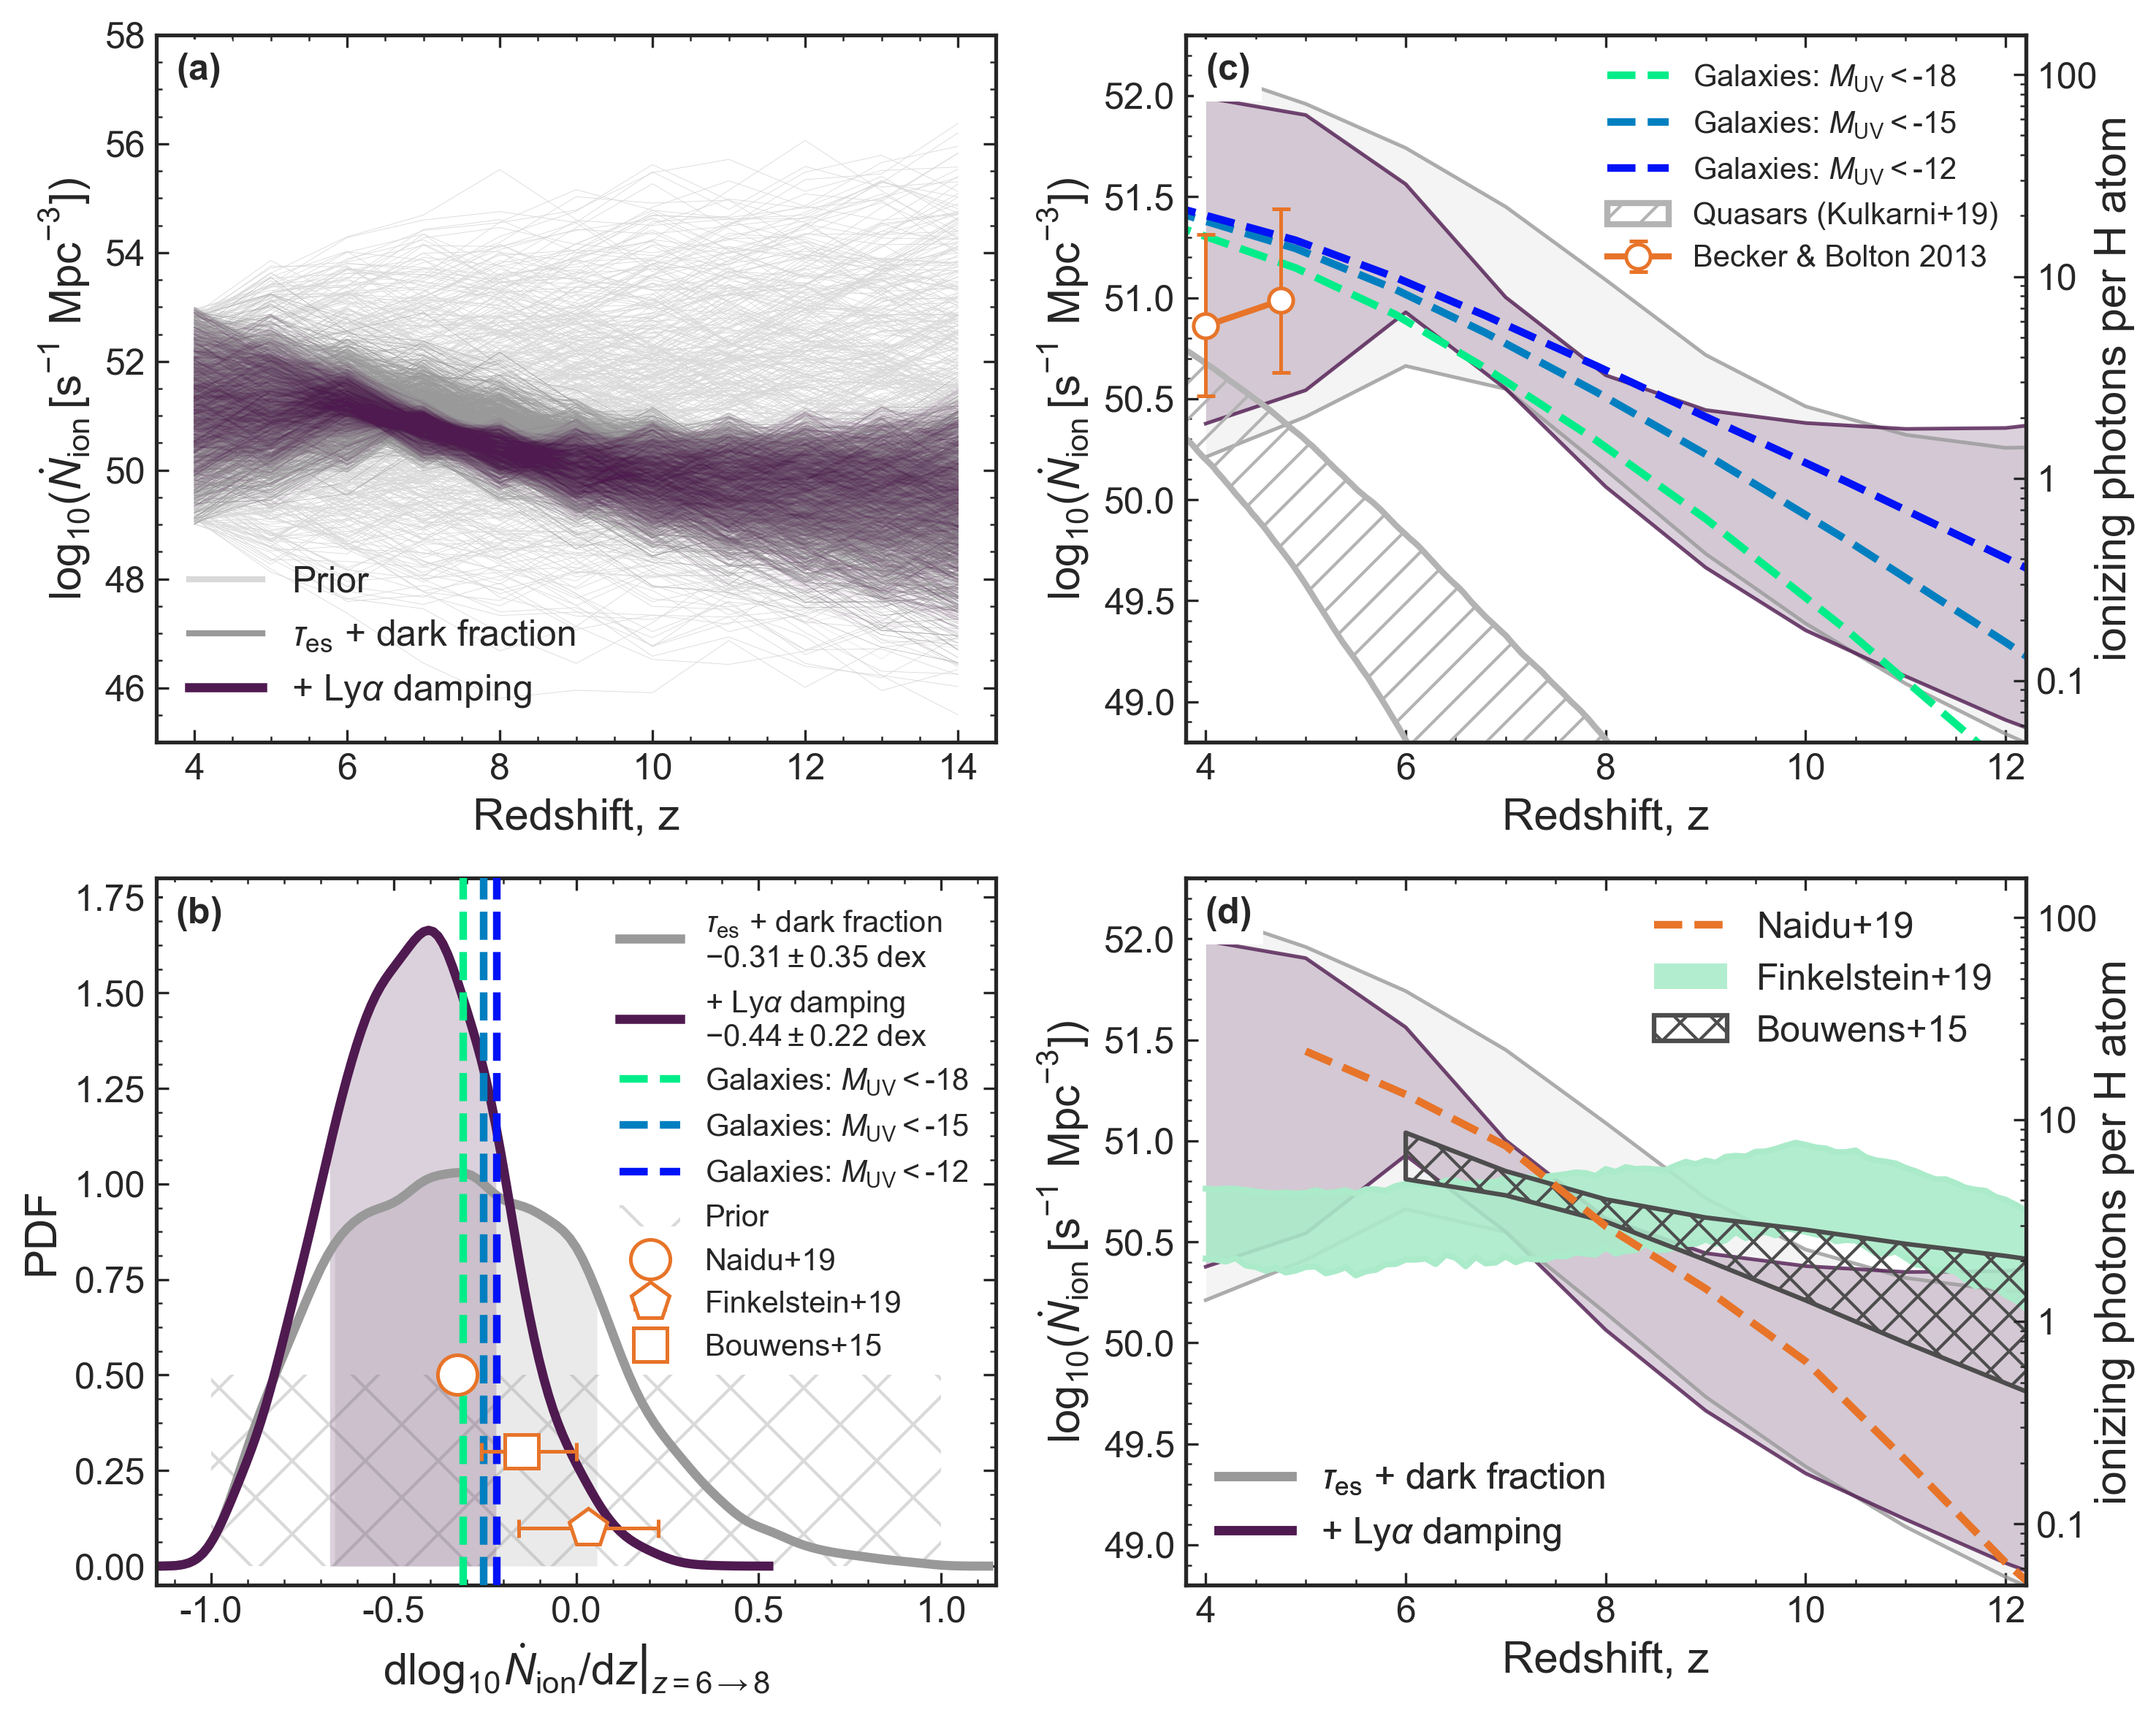

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), dpi=dpi)

#####################################
# Chains
lw_chains = 1.
lw_edge = 1.2

# --------------------------
rasterized=False

# prior
ax1.plot(ztab, random_walks.T, lw=0.2, alpha=1, c=col_prior, rasterized=rasterized, zorder=0)

# --------------------------
# Only model-independent obs
ax1.plot(ztab, nion_pick.T, lw=0.2, alpha=0.6, c=col2, rasterized=rasterized,  zorder=1000)

# --------------------------
# Plus model-dependent obs
ax1.plot(ztab, nion_allobs_pick.T, lw=0.5, alpha=0.05, c=colall, rasterized=rasterized,  zorder=2000)

ln_prior  = mlines.Line2D([], [], lw=2, c=col_prior, label='Prior')
ln_2obs   = mlines.Line2D([], [], lw=2, c=col2,   label=label_2obs)
ln_allobs = mlines.Line2D([], [], lw=lw, c=colall, label=label_allobs)
lines = [ln_prior, ln_2obs, ln_allobs]

ax1.legend(handles=lines, loc='lower left')

ax1.set_xlabel(label_z)
ax1.set_ylabel(label_Nion)

ax1.set_ylim(45., 58.)

#####################################
# Simple models

# --------------------------
# Only model-independent obs
ax2.plot(ztab, nion_16, lw=lw_edge, color=col2, zorder=10, alpha=0.8)#label=label_2obs)
ax2.plot(ztab, nion_84, lw=lw_edge, color=col2, zorder=10, alpha=0.8)#label=label_2obs)
ax2.fill_between(ztab, nion_16, nion_84, color=col2, alpha=0.1)

# ------------------------
# Plus model-dependent obs
ax2.plot(ztab, nion_allobs_16, lw=lw_edge, color=colall, zorder=10, alpha=0.8)#, label=label_allobs, )
ax2.plot(ztab, nion_allobs_84, lw=lw_edge, color=colall, zorder=10, alpha=0.8)#, label=label_allobs, )
ax2.fill_between(ztab, nion_allobs_16, nion_allobs_84, color=colall, alpha=0.2)

# --------------------------
# Other models
alpha=0.3

# Kulkarni QSOs
ax2.fill_between(K18['z'], K18['l_68'], K18['u_68'],
                 edgecolor='0.7', facecolor='None', hatch='//', lw=2, alpha=1.,
                 label='Quasars (Kulkarni+19)', zorder=200)

Mlim_plot = np.array([-18., -15., -12.])
s_map = make_cmap_line(sorted(np.append(Mlim_plot, [Mlim_plot.min()-0.5, Mlim_plot.max()+0.5])), c_map='winter_r')
for M in Mlim_plot:
    lognion = lognion_gal(lumdens=10**M15_ldens['%.0f' % (-10*M)], fesc=fesc_test, logxi_ion=log_xiion_test)
    ax2.plot(M15_ldens['z'], lognion, label='Galaxies: $M_\mathrm{UV} < $%.0f' % (M), 
            c=s_map.to_rgba(M), lw=2.5, ls='dashed', zorder=1000)
        
# --------------------------
# Observations
BB13_z4 = np.where(BB13_nion['z'] >= 4.)
plt_errorbar_obs(x=BB13_nion['z'][BB13_z4], y=BB13_nion['nion'][BB13_z4], col=mcol,
                 yerr=[BB13_nion['nion_err_l'][BB13_z4], BB13_nion['nion_err_u'][BB13_z4]],
                 label=BB13_nion['lab'], ms=8, ls='-', ax=ax2, zorder=2010)

# --------------------
# nion per H atom
ax2_perH = ax2.twinx()
ax2_perH.semilogy(ztab, nion_per_Hatom(nion_allobs_16, z=6.), lw=0)

# --------------------

ax2.legend(loc='upper right', ncol=1, framealpha=1., frameon=False, fontsize=10)

ax2.set_xlabel(label_z)
ax2.set_ylabel(label_Nion)

ax2.set_xlim(3.8, 12.2)
ax2.set_ylim(48.8, 52.3)

ax2_perH.set_ylabel('ionizing photons per H atom', labelpad=-1)
ax2_perH.set_ylim([nion_per_Hatom(lim) for lim in ax2.get_ylim()])
ax2_perH.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

#####################################
# dlogNion/dz
# z1, z2 = 6., 8.
xprior = np.linspace(-1.,1.)
ax3.fill_between(xprior, 0., 0.5*np.ones_like(xprior), 
#                  zorder=0, color=col_prior, lw=2, label='Prior')
                 hatch='x', 
                 zorder=0, facecolor='w', edgecolor=col_prior, label='Prior')

plot_dist(nion_samples, ztab=ztab, z1=z1, z2=z2, ax=ax3,
        kde_kws={'bw':0.05, 'lw':lw, 'color':col2}, plot_conf=True, label=label_2obs)
plot_dist(nion_allobs_samples, ztab=ztab, z1=z1, z2=z2, ax=ax3,
        kde_kws={'bw':0.05,'lw':lw, 'color':colall}, plot_conf=True, label=label_allobs)

# ------------------
# Other models
plt_errorbar_obs(dnion_N19['dnion'], 0.5, xerr=dnion_N19['err'], col=mcol,
                 marker='o', ms=13, ax=ax3, zorder=100, label=dnion_N19['label'])   # From paper
plt_errorbar_obs(dnion_F19['dnion'], 0.1, xerr=dnion_F19['err'], col=mcol,
                 marker='p', ms=13, ax=ax3, zorder=100, label=dnion_F19['label'])   # From paper
plt_errorbar_obs(dnion_B15['dnion'], 0.3, xerr=dnion_B15['err'],col=mcol,
                 marker='s', ms=11, ax=ax3, zorder=100, label=dnion_B15['label'])   # From paper

# plt_errorbar_obs(-0.13, 0.3, xerr=[[0.12],[0.12]], marker='^', ms=10, ax=ax3, zorder=100, label='Robertson+15') # I fit it

# Galaxies
Mlim_plot = np.array([-18., -15., -12.])
s_map = make_cmap_line(sorted(np.append(Mlim_plot, [Mlim_plot.min()-0.5, Mlim_plot.max()+0.5])), c_map='winter_r')
for M in Mlim_plot:
    lognion = lognion_gal(lumdens=10**M15_ldens['%.0f' % (-10*M)], fesc=fesc_test, logxi_ion=log_xiion_test)
        
    dlognion = (lognion[M15_ldens['z']==7.9] - lognion[M15_ldens['z']==5.9])/2.
    ax3.axvline(dlognion, label='Galaxies: $M_\mathrm{UV} < $%.0f' % (M), 
                c=s_map.to_rgba(M), lw=2.5, ls='dashed', zorder=10)
    

#---------------
ax3.legend(fontsize=10)

ax3.set_ylabel('PDF')
ax3.set_xlabel(r'$\left.\mathrm{d}\log_{10}\dot{N}_\mathrm{ion}/\mathrm{d}z \right|_{z=%.0f \rightarrow %.0f}$' % (z1, z2))

ax3.set_xlim(-1.15, 1.15)
ax3.set_ylim(-0.05, 1.8)


#####################################
# Other models

# --------------------------
# Only model-independent obs
ax4.plot(ztab, nion_16, lw=lw_edge, color=col2, zorder=10, alpha=0.8)#label=label_2obs)
ax4.plot(ztab, nion_84, lw=lw_edge, color=col2, zorder=10, alpha=0.8)#label=label_2obs)
ax4.fill_between(ztab, nion_16, nion_84, color=col2, alpha=0.1)

# ------------------------
# Plus model-dependent obs
ax4.plot(ztab, nion_allobs_16, lw=lw_edge, color=colall, zorder=10, alpha=0.8)#, label=label_allobs, )
ax4.plot(ztab, nion_allobs_84, lw=lw_edge, color=colall, zorder=10, alpha=0.8)#, label=label_allobs, )
ax4.fill_between(ztab, nion_allobs_16, nion_allobs_84, color=colall, alpha=0.2)

# --------------------------
# Other models
alpha=0.3

c_mod1 = 6
c_mod2 = 2

ax4.plot(N19_z, N19_nion, c=col_N19, lw=2.5, ls='dashed', label='Naidu+19', zorder=1050)

ax4.plot(F19['z'], F19['l_68'], color=col_F19, lw=2, zorder=122)
ax4.plot(F19['z'], F19['u_68'], color=col_F19, lw=2, zorder=122)
ax4.fill_between(F19['z'], F19['l_68'], F19['u_68'], 
                 color=col_F19, alpha=0.9,
                 label='Finkelstein+19', zorder=120)
ax4.fill_between(B15['z'], B15['l_68'], B15['u_68'], 
                 edgecolor='0.3', alpha=1.,
                 facecolor='None', lw=1.5,
                 hatch='xx', 
                 label='Bouwens+15', zorder=130)


# --------------------
# nion per H atom
ax4_perH = ax4.twinx()
ax4_perH.semilogy(ztab, nion_per_Hatom(nion_allobs_16, z=6.), lw=0)

# --------------------
# legends
ln_2obs   = mlines.Line2D([], [], lw=lw, c=col2,   label=label_2obs)
ln_allobs = mlines.Line2D([], [], lw=lw, c=colall, label=label_allobs)
lines = [ln_2obs, ln_allobs]

leg = plt.legend(handles=lines, loc='lower left')
plt.gca().add_artist(leg) 

ax4.legend(loc='upper right', ncol=1, framealpha=1., frameon=False)

ax4.set_xlabel(label_z)
ax4.set_ylabel(label_Nion)

ax4.set_xlim(ax2.get_xlim())
ax4.set_ylim(ax2.get_ylim())

ax4_perH.set_ylabel('ionizing photons per H atom', labelpad=-1)
ax4_perH.set_ylim([nion_per_Hatom(lim) for lim in ax2.get_ylim()])
ax4_perH.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

# -------------
# Label plots
ax1.annotate(r'$\mathbf{(a)}$', xy=(0.05,0.95), xycoords='axes fraction', ha='center', va='center', zorder=2000, bbox=dict(facecolor='w', alpha=1))
ax2.annotate(r'$\mathbf{(c)}$', xy=(0.05,0.95), xycoords='axes fraction', ha='center', va='center', zorder=2000, bbox=dict(facecolor='w', alpha=1))
ax3.annotate(r'$\mathbf{(b)}$', xy=(0.05,0.95), xycoords='axes fraction', ha='center', va='center', zorder=2000, bbox=dict(facecolor='w', alpha=1))
ax4.annotate(r'$\mathbf{(d)}$', xy=(0.05,0.95), xycoords='axes fraction', ha='center', va='center', zorder=2000, bbox=dict(facecolor='w', alpha=1))

fig.subplots_adjust(hspace=0.17)
plt.tight_layout()
plt.savefig('figs/%snion_all_Mlim.pdf' % test)

## dNion/dz

How likely is dNion/dz > a certain value?

In [27]:
def niondz_dist(samples, ztab, z1=6., z2=8.):
    dz = z2 - z1
    dist = (samples[:,np.where(ztab == z2)] - samples[:,np.where(ztab == z1)]).ravel()/dz
    return dist

def p_samples(dist, low, high=1):
    p = (len(dist[np.where((dist>low) & (dist < high))[0]])/len(dist))
    return p

nion_dz_2obs_samples   = niondz_dist(nion_samples, ztab=ztab, z1=z1, z2=z2)
nion_dz_allobs_samples = niondz_dist(nion_allobs_samples, ztab=ztab, z1=z1, z2=z2)

print('%.f%% of samples have dnion/dz > 0' % (100.*p_samples(nion_dz_2obs_samples, low=0., high=1.)))
print('%.f%% of samples have dnion/dz > 0' % (100.*p_samples(nion_dz_allobs_samples, low=0., high=1.)))
 
print('\n%.f%% of samples have dnion/dz > galaxies lower bound' % (100.*p_samples(nion_dz_2obs_samples,   low=dnion_M15['dnion'][0])))
print('%.f%% of samples have dnion/dz > galaxies lower bound\n' % (100.*p_samples(nion_dz_allobs_samples, low=dnion_M15['dnion'][0])))

for M in Mlim_plot:
    print('%.f%% of samples have dnion/dz > galaxies Muv < %.2f lower bound: %.2f' % (100.*p_samples(nion_dz_allobs_samples, low=dnion_M15_Muv(Muv=M)), M, dnion_M15_Muv(Muv=M)))


21% of samples have dnion/dz > 0
3% of samples have dnion/dz > 0

50% of samples have dnion/dz > galaxies lower bound
28% of samples have dnion/dz > galaxies lower bound

28% of samples have dnion/dz > galaxies Muv < -18.00 lower bound: -0.31
20% of samples have dnion/dz > galaxies Muv < -15.00 lower bound: -0.25
16% of samples have dnion/dz > galaxies Muv < -12.00 lower bound: -0.22


# Neutral fraction and tau

In [16]:
z_He_reion = 4.

def nion_mod(z, theta):
    """Theta values in s-1 Mpc-3, need to be s-1 cm-3 for solving dQ/dz"""
    nion = (10**theta)/cm3_to_Mpc3
    return nion

big_ztab   = np.linspace(0.,ztab.max(), 100)  
reion.ztab = ztab

In [17]:
Nsample = 1000

# Using samples
xHII_sample   = np.zeros((Nsample,len(big_ztab)))
tau_sample = np.zeros((Nsample,len(big_ztab)))
for i, nion in enumerate(nion_pick):
    reion.nion_z = nion_mod(z=ztab, theta=nion) 
    reion.Q_solve()   
    xHII_sample[i,:] = reion.Q_interp(big_ztab)
    tau_sample[i,:]  = np.array([reion.tau(z, z_He=z_He_reion) for z in big_ztab])
    
xHII_allobs_sample   = np.zeros((Nsample,len(big_ztab)))
tau_allobs_sample = np.zeros((Nsample,len(big_ztab)))
for i, nion in enumerate(nion_allobs_pick):
    reion.nion_z = nion_mod(z=ztab, theta=nion) 
    reion.Q_solve()   
    xHII_allobs_sample[i,:] = reion.Q_interp(big_ztab)
    tau_allobs_sample[i,:]  = np.array([reion.tau(z, z_He=z_He_reion) for z in big_ztab])
reion.ztab = ztab

## Neutral Fraction

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


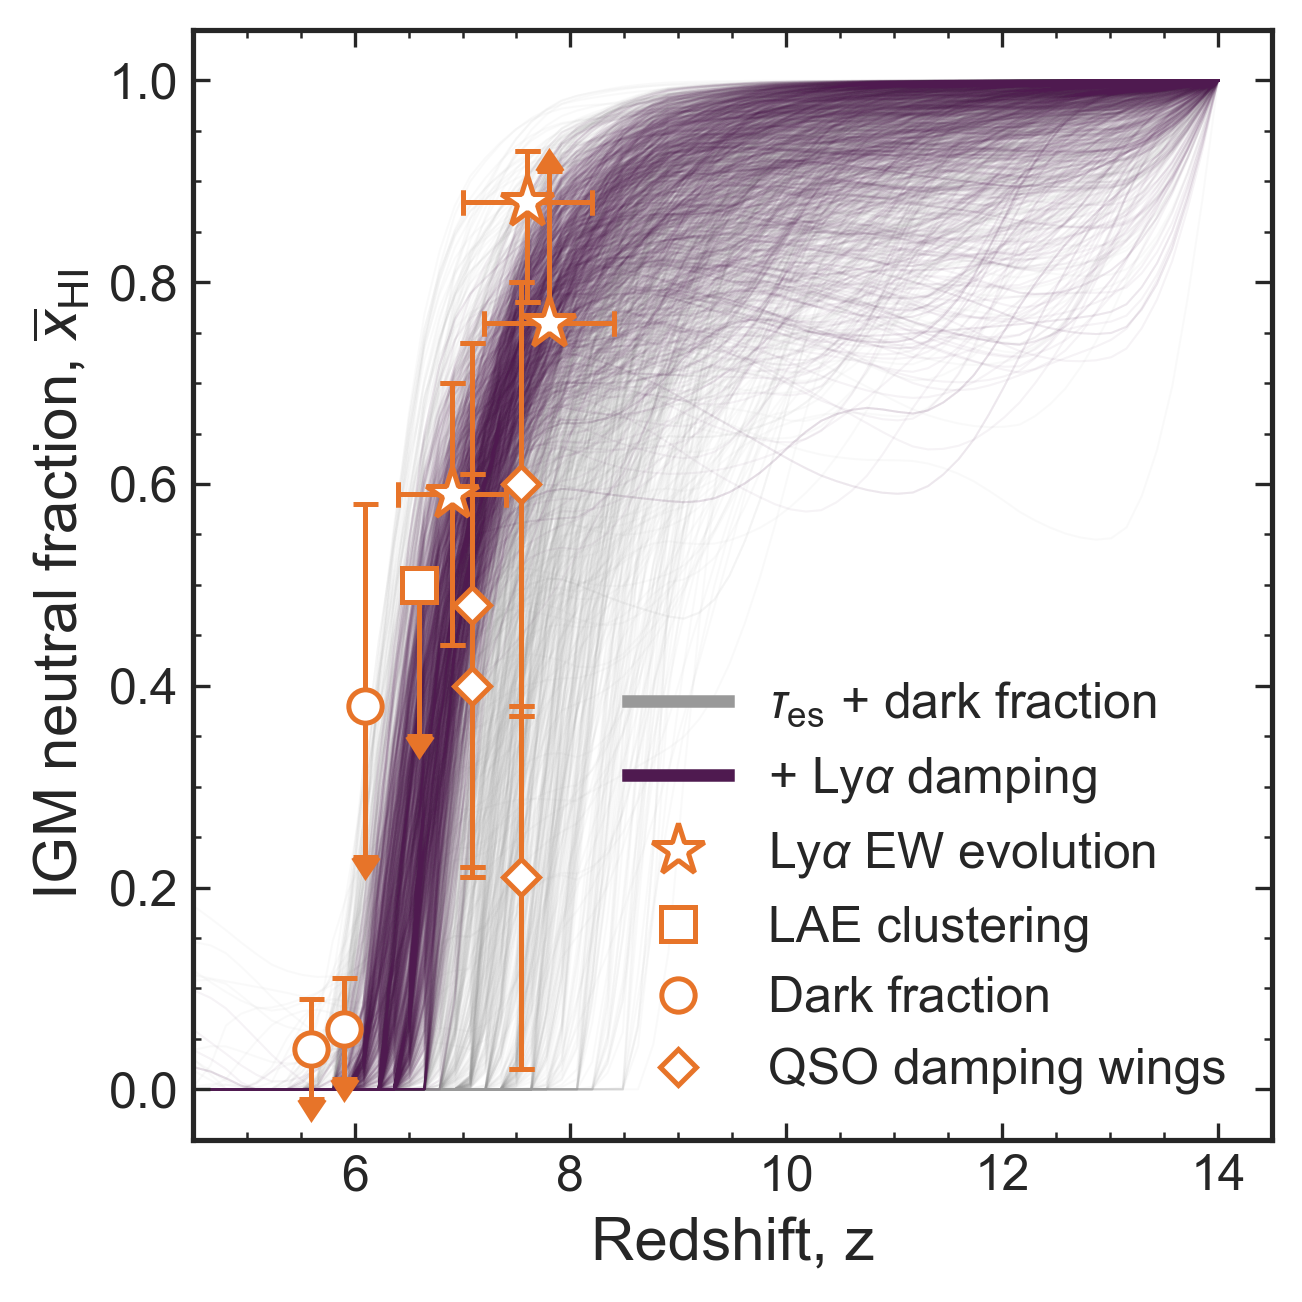

In [32]:
fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=dpi)

mcol = '0.5'
mcol = '#e77429'
lw_chains = 0.5 

# Only model-independent obs
plt.plot(big_ztab, 1-xHII_sample.T, lw=lw_chains, alpha=0.05, c=col2, zorder=0)

# including model-dependent obs
plt.plot(big_ztab, 1-xHII_allobs_sample.T, lw=lw_chains, alpha=0.05, c=colall, zorder=0)

# for i, ob in enumerate(xHII_obs):
for i, ob in enumerate(xHI_obs):

    yerrs  = np.array(ob['xHI_err'])

    # Limits
    lims = np.array(ob['lim'])
    uplims = (lims == 'up')
    lolims = (lims == 'low')
        
    yerrs[0][uplims] = 0.15
    try:
        yerrs[0][np.where(ob['xHI'][uplims] < 0.1)] = 0.05
    except:
        pass
    yerrs[1][lolims] = 0.15
    
    # z_err
    try:
        xerrs = ob['z_err']
    except:
        xerrs = None
 
    plt_errorbar_obs(x=ob['z'], y=ob['xHI'], 
                     yerr=yerrs, xerr=xerrs, 
                     col=mcol,
                     uplims=uplims, lolims=lolims,
                     marker=ob['sym'], ms=ob['s']-5, 
                     label=ob['lab'])
    # Error bars
    plt_errorbar_obs(x=ob['z'], y=ob['xHI'], 
                     yerr=yerrs, xerr=xerrs, col=mcol,
                     marker=None)

# Inferred history
ln_2obs   = mlines.Line2D([], [], lw=lw, c=col2,   label=label_2obs)
ln_allobs = mlines.Line2D([], [], lw=lw, c=colall, label=label_allobs)

# Observed constraints minus errors bars
handles, labels = plt.gca().get_legend_handles_labels()
handles_noeb    = [h[0] for h in handles]
handles_noeb.append(ln_2obs)
labels.append(label_2obs)
handles_noeb.append(ln_allobs)
labels.append(label_allobs)
reorder = [4, 5, 0, 1, 2, 3]
labels  = [labels[i] for i in reorder]
handles_noeb = [handles_noeb[i] for i in reorder]
plt.legend(handles_noeb, labels, numpoints=1, loc='lower right')

plt.xlabel(label_z)
plt.ylabel(label_xHI)
ax.set_xlim(4.5, 14.5)
ax.set_ylim(-0.05,1.05)

# make_Gyr_axis(ax, age_list=[0.4, 0.6, 0.8, 1.,])
# ax.minorticks_on()

plt.tight_layout()
plt.savefig('figs/%shistory.pdf' % test)

## xHI midpoint and delta z

In [18]:
# Midpoint (xHI = 0.5)
z_reion_mid_2obs   = big_ztab[np.argmin(np.abs(xHII_sample - 0.5), axis=1)]
z_reion_mid_allobs = big_ztab[np.argmin(np.abs(xHII_allobs_sample - 0.5), axis=1)]

# Find redshift where first xHI=1
z_reion_end_2obs   = big_ztab[((xHII_sample < 1).argmax(axis=1)) - 1]
z_reion_end_allobs = big_ztab[((xHII_allobs_sample < 1).argmax(axis=1)) - 1]

xHI_high, xHI_low = 0.9, 0.1
dz_reion_2obs   = big_ztab[np.argmin(np.abs(xHII_sample - xHI_low), axis=1)] - big_ztab[np.argmin(np.abs(xHII_sample - xHI_high), axis=1)]
dz_reion_allobs = big_ztab[np.argmin(np.abs(xHII_allobs_sample - xHI_low), axis=1)] - big_ztab[np.argmin(np.abs(xHII_allobs_sample - xHI_high), axis=1)]

In [19]:
def confidence_levels_2D(x, y, sigma=[2., 1.], bins=5):
    """
    https://stackoverflow.com/questions/35225307/set-confidence-levels-in-seaborn-kdeplot
    """
    
    # Make a 2d normed histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, normed=True)

    norm = H.sum() # Find the norm of the sum
    
    # Set contour levels
    contours = scipy.special.erf(np.array(sigma)/np.sqrt(2.))
    
    # Set target levels as percentage of norm
    targets = norm*contours

    # Take histogram bin membership as proportional to Likelihood
    # This is true when data comes from a Markovian process
    def objective(limit, target):
        w = np.where(H > limit)
        count = H[w]
        return count.sum() - target

    # Find levels by summing histogram to objective
    levels = [scipy.optimize.bisect(objective, H.min(), H.max(), args=target) for target in targets]
    
    # For nice contour shading with seaborn, define top level
    level_top = H.max() + 0.2
    levels.append(level_top)

    return levels

def corner_plot_2D(x1, y1, x2, y2, 
                   c1=col2, c2=colall,
                   bw=0.3,
                   xmin=5.8, xmax=9.6, ymin=0., ymax=10.,
                   xlabel=r'$z(\overline{x}_\mathrm{HI} = 0.5)$',
                   ylabel=r'$\Delta z_\mathrm{reion}$',
                   save=False, plotname=''):
    
    # Pass levels to normed kde plot
    fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=dpi)

    # create new axes on the right and on the top of the current axes
    # The first argument of the new_vertical(new_horizontal) method is
    # the height (width) of the axes to be created in inches.
    divider = make_axes_locatable(ax)
    axHistx = divider.append_axes("top", 0.8, pad=0., sharex=ax)
    axHisty = divider.append_axes("right", 0.8, pad=0., sharey=ax)

    # make some labels invisible
    plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),
             visible=False)

    # 2D hist
    sns.kdeplot(x1, y1, levels=confidence_levels_2D(x1, y1), 
                bw=bw, shade=False, ax=ax, color=c1, label=label_2obs, alpha=0.5)
    sns.kdeplot(x2, y2, levels=confidence_levels_2D(x2, y2),
                bw=bw, shade=True, alpha=1, ax=ax, color=c2, label=label_allobs)

    # z_reion hist
    sns.kdeplot(x1, ax=axHistx, bw=bw, shade=False, color=c1)
    sns.kdeplot(x2, ax=axHistx, bw=bw, shade=True,  color=c2)

    # dz hist
    sns.kdeplot(y1, ax=axHisty, shade=False, color=c1, vertical=True)
    sns.kdeplot(y2, ax=axHisty, shade=True,  color=c2, vertical=True)

    # Corner
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ax.legend(fontsize=12)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    axHistx.axis('off')
    axHisty.axis('off')

    fig.tight_layout()

    print('2 obs:')
    med, low, high = confidence_interval(x1)
    print('%s = %.2f_{-%.2f}^{+%.2f}' % (xlabel, med, med-low, high-med))
    med, low, high = confidence_interval(y1)
    print('%s           = %.2f_{-%.2f}^{+%.2f}' % (ylabel, med, med-low, high-med))

    print('\nAll obs:')
    med, low, high = confidence_interval(x2)
    print('%s = %.2f_{-%.2f}^{+%.2f}' % (xlabel, med, med-low, high-med))
    med, low, high = confidence_interval(y2)
    print('%s           = %.2f_{-%.2f}^{+%.2f}' % (ylabel, med, med-low, high-med))
    
    if save:
        plt.savefig('figs/%szreion_joint%s.pdf' % (test, plotname))

2 obs:
Mid-point, $z(\overline{x}_\mathrm{HI} = 0.5)$ = 7.49_{-0.71}^{+0.71}
Duration, $\Delta z_\mathrm{reion}$           = 2.26_{-0.85}^{+2.26}

All obs:
Mid-point, $z(\overline{x}_\mathrm{HI} = 0.5)$ = 6.93_{-0.14}^{+0.14}
Duration, $\Delta z_\mathrm{reion}$           = 2.83_{-0.99}^{+2.83}


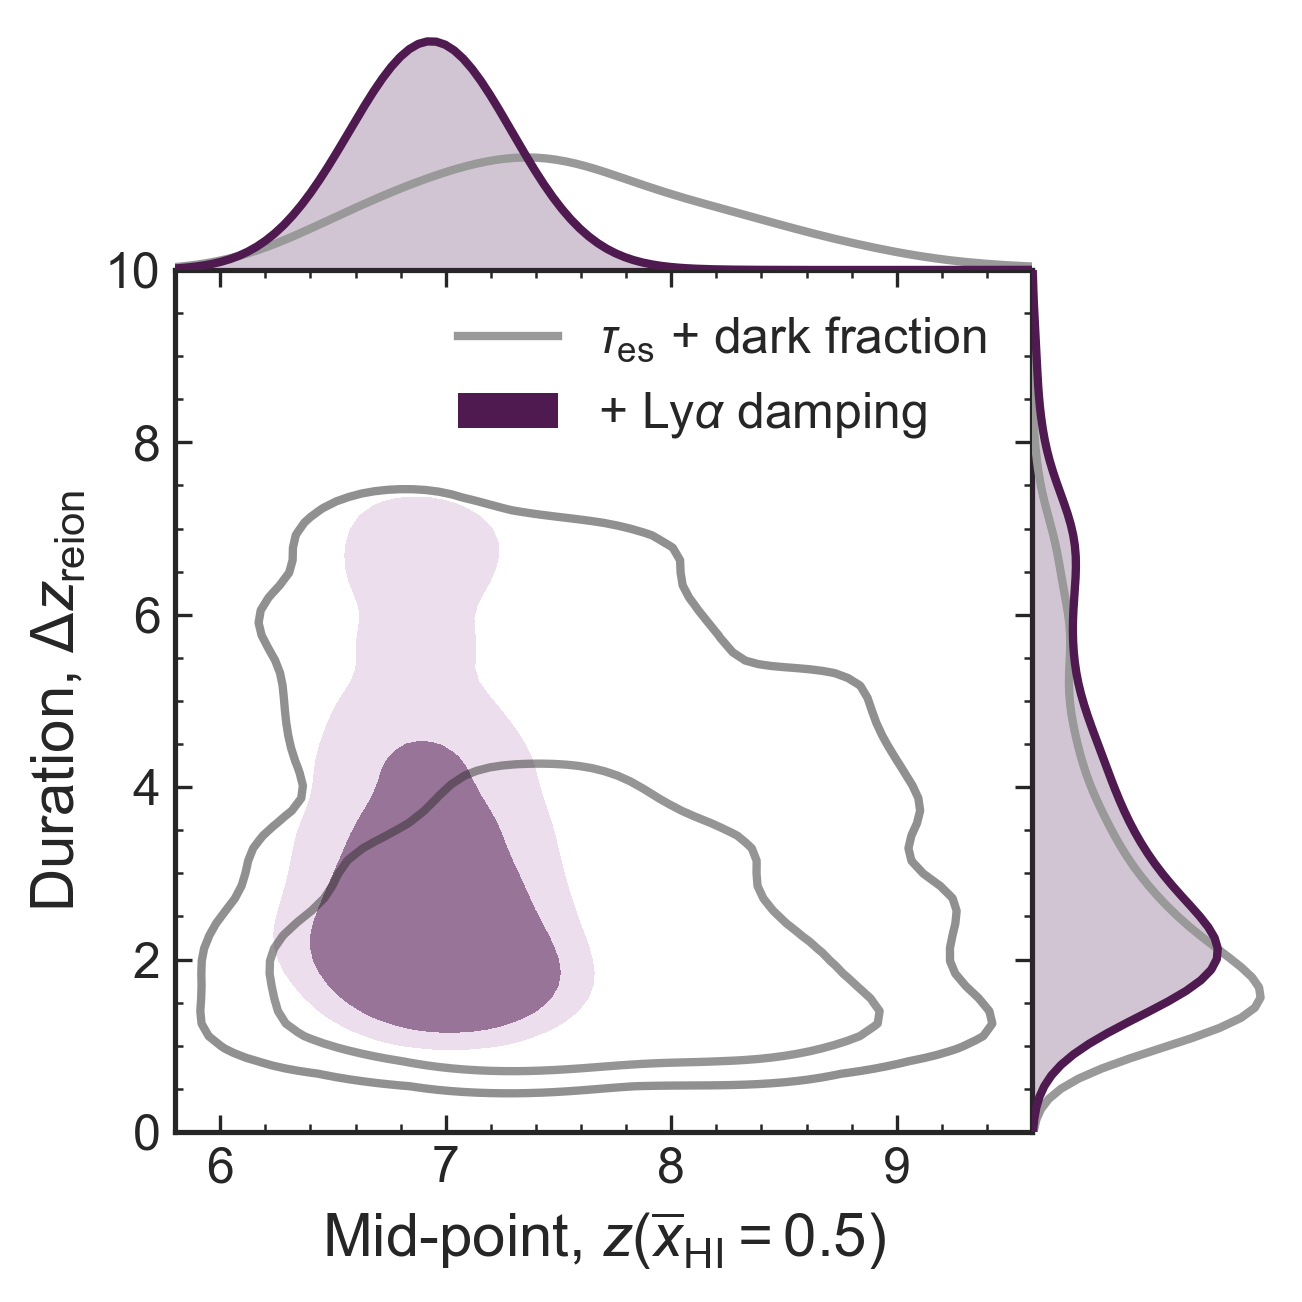

In [20]:
corner_plot_2D(x1=z_reion_mid_2obs, y1=dz_reion_2obs, 
               x2=z_reion_mid_allobs, y2=dz_reion_allobs,
               xlabel=r'Mid-point, $z(\overline{x}_\mathrm{HI} = 0.5)$',
               ylabel=r'Duration, $\Delta z_\mathrm{reion}$',
               bw=0.3, save=True)

## Tau

0.05698858733475014 0.006083975313309864
0.05285308049749942 0.003755051699597505


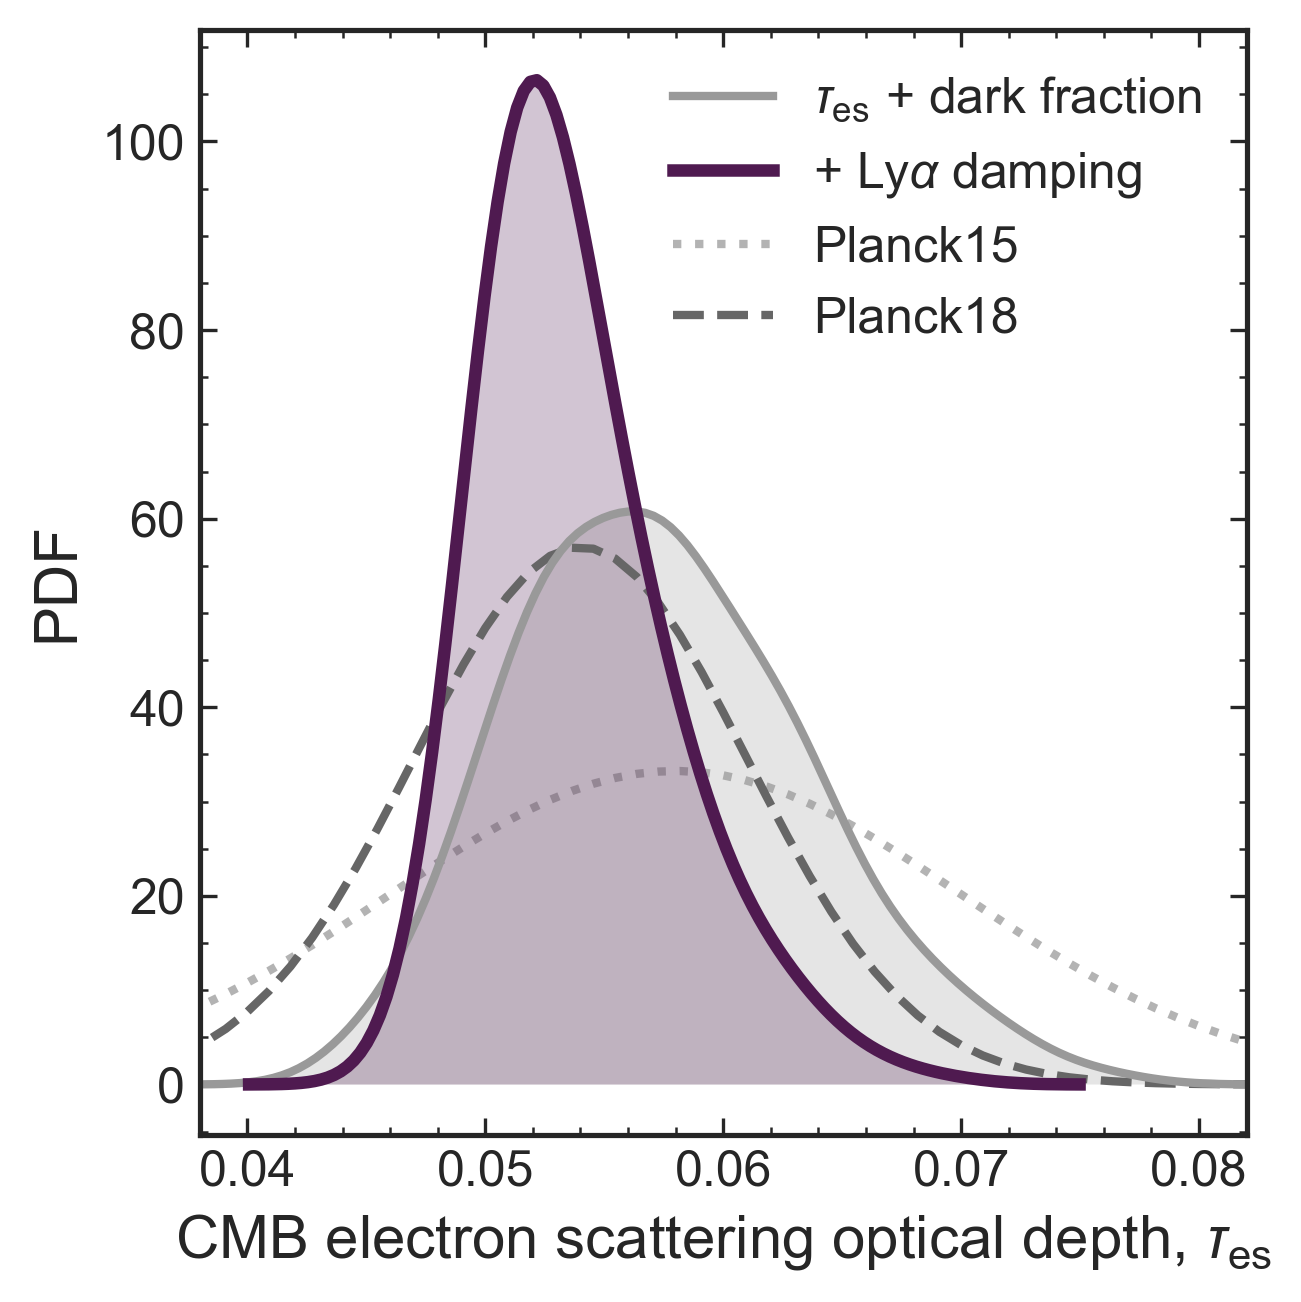

In [38]:
# Histogram
plt.figure(figsize=(4.5,4.5), dpi=dpi)

# Only model-independent obs
sns.kdeplot(tau_sample[:,-1], lw=2, bw=0.002, shade=True, color=col2, label=label_2obs)

# including model-dependent obs
sns.kdeplot(tau_allobs_sample[:,-1], bw=0.002, shade=True, color=colall,  lw=3, label=label_allobs)

print(np.median(tau_sample[:,-1]), np.std(tau_sample[:,-1]))
print(np.median(tau_allobs_sample[:,-1]), np.std(tau_allobs_sample[:,-1]))

# Planck
x = np.linspace(0.01, 0.1, 100)
plt.plot(x, scipy.stats.norm.pdf(x, loc=Planck15['tau'], scale=Planck15['tau_err']), 
         ls='dotted', color='0.7', label='Planck15', zorder=0)
plt.plot(x, scipy.stats.norm.pdf(x, loc=Planck18['tau'], scale=Planck18['tau_err']), 
         ls='dashed', color='0.4', label='Planck18', zorder=1)

plt.xlim(0.038,0.082)

plt.legend(loc='upper right')
plt.xlabel(label_tau)
plt.ylabel('PDF')

plt.tight_layout()
plt.savefig('figs/tau_hist_Hez=%.0f.pdf' % z_He_reion)